In [1]:
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
# from IPython.display import display, HTML

from pykat import finesse
from pykat.commands import *
pykat.init_pykat_plotting(dpi=90)

from pprint import pprint as pprint

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
# base of configurations, without Southern section
basekat = finesse.kat()
basecode = """
# lasers
const Pin 125
const PLO1 1
# spaces
const lx 1.6
const ly 1.55
const Lx 4k
const Ly 4k
const lprc 53
# mirrors
const Tprm 0.3
const Rprm 0.7
const Titm 0.014
const Ritm 0.986
const Tetm 6E-6
const Retm 0.999994
const Tsrm 0.2
const Rsrm 0.8

# carrier laser
l laser $Pin 0 nLaser

# power recycling
m PRM $Rprm $Tprm 0 nLaser nPRM
s sBStoPRM $lprc nPRM nBSi

# central beam splitter
# remember to set angle of incidence = 45°
bs BS 0.5 0.5 0 45 nBSi nBSr nBSt nBSo
s sBStoYarm $ly nBSr nY0
s sBStoXarm $lx nBSt nX0

# Y arm (perpendicular)
m mY1 $Ritm $Titm 0 nY0 nY1
s sY $Ly nY1 nY2
m mY2 $Retm $Tetm 0 nY2 nY3

# X arm (parallel)
m mX1 $Ritm $Titm 0 nX0 nX1
s sX $Lx nX1 nX2
m mX2 $Retm $Tetm 0 nX2 nX3

# signal recycling
# nBSo to nSRM left disconnected for now
# is connected differently in kat1 and kat2
m SRM $Rsrm $Tsrm 0 nSRM nDark
s sSRMtohdBS 0 nDark nhdBSi # null length space

# (balanced) homodyne detection
l LO1 $PLO1 0 nLO1
bs hdBS 0.5 0.5 0 45 nhdBSi nhdBSr nhdBSt nLO1
qhd qhd1 180 nhdBSr nhdBSt
hd hd1 180 nhdBSr nhdBSt
"""
basekat.parse(basecode)

# pprint((basekat.components, basekat.detectors, basekat.commands))

In [3]:
def create_kat1(lsrc):
    """configuration 1: connecting nBSo and nSRM with a space
    lsrc in m
    """
    kat1 = deepcopy(basekat)
    kat1code = """
    const lsrc {0}
    s sBStoSRM $lsrc nBSo nSRM
    """.format(lsrc)
    kat1.parse(kat1code)
    
    return kat1


def create_kat2(lsrc, gain=10):
    """configuration 2: connecting nBSo and nSRM with a nle
    lsrc in m, gain in field dB
    """
    kat2 = deepcopy(basekat)
    kat2code = """
    const lsrc {0}
    const halflsrc {1}
    s sBStonle $halflsrc nBSo nnle11
    nle nle1 {2} 0 nnle11 nnle12 # gain defaults to 10 dB, angle = 0
    s snletoSRM $halflsrc nnle12 nSRM  
    """.format(lsrc, lsrc/2, gain)
    kat2.parse(kat2code)
    
    return kat2

In [4]:
def noise_transfer(kat, fmin=1, fmax=10e9):
    """calculates noise transfer function for kat1 or kat2
    noise enters through every open port and lossy optic
    """
    noisekat = deepcopy(kat)
    noisekat.verbose = False
    # initial frequency for fsig doesn't matter   
    noisecode = """ 
    fsig noise 100
    xaxis noise f lin {0} {1} 1000
    """.format(fmin, fmax)
    noisekat.parse(noisecode)
    noiseout = noisekat.run()
    
    return noiseout


def signal_transfer(kat, fmin=1, fmax=10e9):
    """calculates signal transfer function for kat1 or kat2
    for input at mX2
    """
    signalkat = deepcopy(kat)
    signalkat.verbose = False
    # initial frequency for fsig doesn't matter   
    signalcode = """          
    fsig sig1 mX2 10k 0
    xaxis sig1 f lin {0} {1} 1000
    """.format(fmin, fmax)
    signalkat.parse(signalcode)
    signalout = signalkat.run()    
    
    return signalout


def noise_limited_sensitivity(kat, fmin=1, fmax=10e9):
    """calculates SNR for signal against noise for kat1 or kat2
    returns frequency array and SNR array
    """
    noiseout = noise_transfer(kat, fmin, fmax)
    signalout = signal_transfer(kat, fmin, fmax)
    
    return noiseout.x, signalout['hd1']/noiseout['qhd1']

In [5]:
class IFO(object):
    def __init__(self, confignum, lsrc, title, filetag):
        """instance of kat1 or kat2
        lsrc is space from central BS to SRM
        title is appended to all plot titles
        filetag is appended to all filenames
        """
        self.lsrc = lsrc
        self.title = title
        self.filetag = filetag+".pdf"
        
        if confignum == 1:
            self.kat = create_kat1(lsrc)
        elif confignum == 2:
            self.kat = create_kat2(lsrc)
        else:
            raise ValueError
            
    def plot_transfer_fns_and_sensitivity(self, fmin=1, fmax=10e9, show=True):
        """plot transfer functions and noise limited sensitivity"""
        noise_out = noise_transfer(self.kat, fmin, fmax)
        signal_out = signal_transfer(self.kat, fmin, fmax)
        
        noise_plot_title = "noise transfer fn - "
        noise_filename = "aLIGO_noise_transfer_fn"
        noise_out.plot(detectors=['qhd1'], show=show,
                       title=noise_plot_title+self.title,
                       filename=noise_filename+self.filetag)
        
        signal_plot_title = "signal transfer fn -"
        signal_filename = "aLIGO_signal_transfer_fn"
        signal_out.plot(detectors=['hd1'], show=show,
                        title=signal_plot_title+self.title,
                        filename=signal_filename+self.filetag)        
        
        freqAxis = noise_out.x
        snr = signal_out['hd1']/noise_out['qhd1']

        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(freqAxis, snr)
        ax.set(title="QM noise limited sensitivity - "+self.title,
               xlabel="frequency / Hz")
        ax.set_ylabel(r"SNR = $\frac{hd}{qhd}$ / $\frac{1}{Hz^{1/2}}$", fontsize="large")
        fig.savefig("aLIGO_qm_noise_limited_sensitivity"+self.filetag)
                

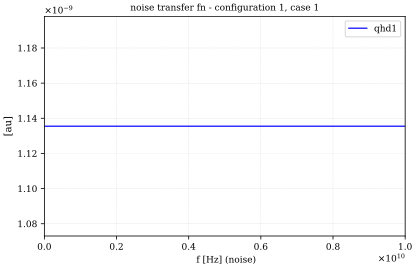

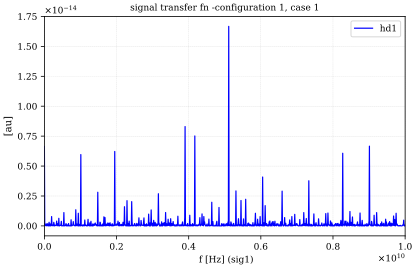

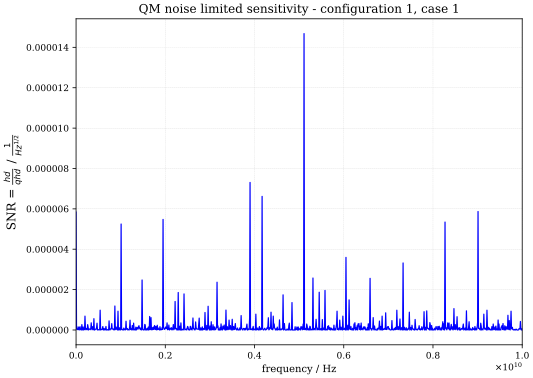

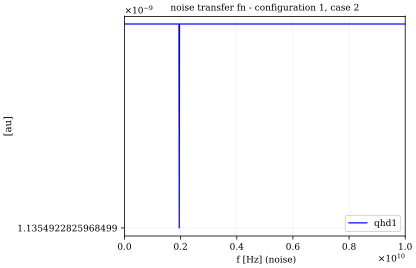

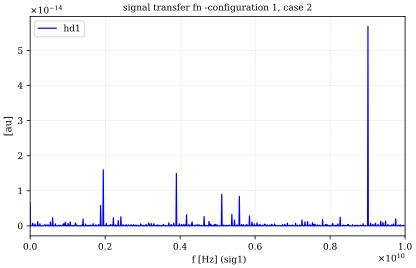

Parsing `nle nle1 10 0 nnle11 nnle12` into pykat object not implemented yet, added as extra line.


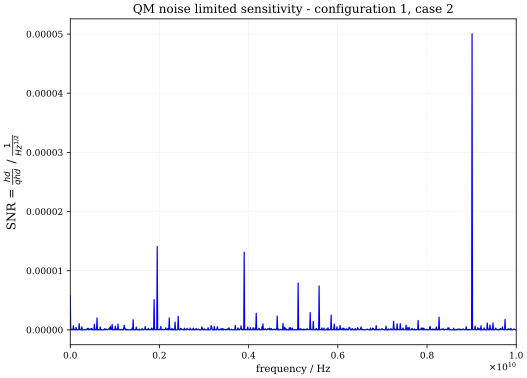

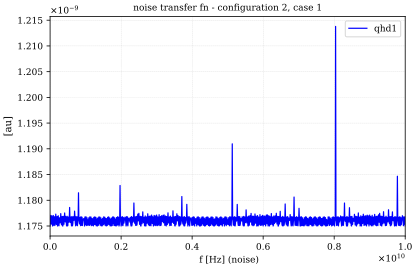

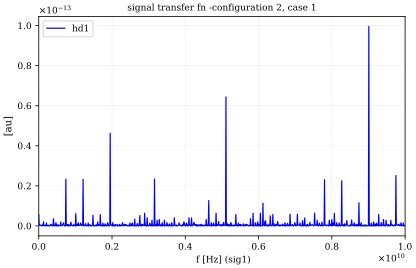

Parsing `nle nle1 10 0 nnle11 nnle12` into pykat object not implemented yet, added as extra line.


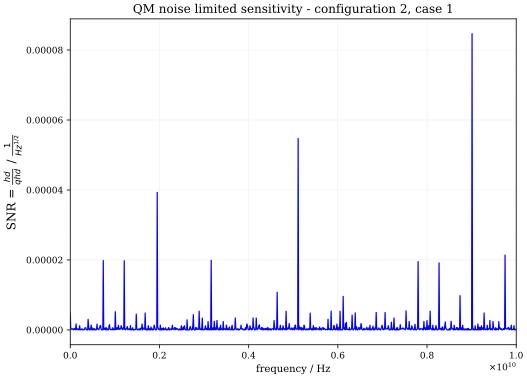

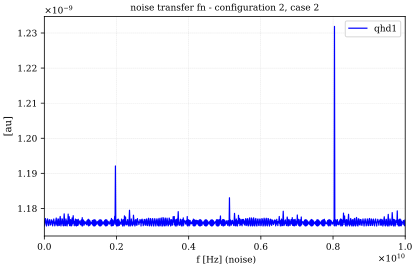

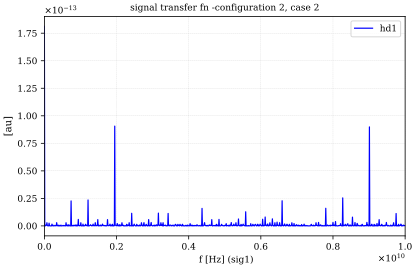

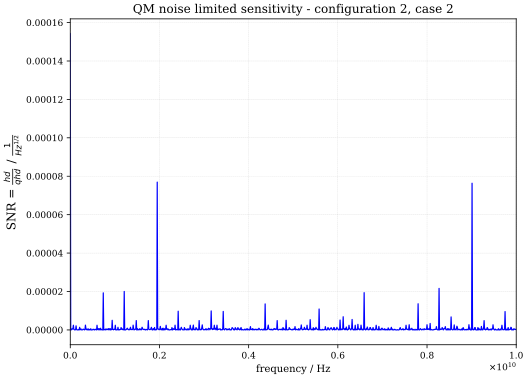

In [6]:
k11 = IFO(1, 53,   "configuration 1, case 1", "_k11")
k11.plot_transfer_fns_and_sensitivity()

k12 = IFO(1, 2000, "configuration 1, case 2", "_k12")
k12.plot_transfer_fns_and_sensitivity()

k21 = IFO(2, 53,   "configuration 2, case 1", "_k21")
k21.plot_transfer_fns_and_sensitivity()

k22 = IFO(2, 2000, "configuration 2, case 2", "_k22")
k22.plot_transfer_fns_and_sensitivity()

In [7]:
# checking IFO tuning by seeing if circulating power in arms is close to 800kW
check_tuning_kat = deepcopy(k11.kat)
check_tuning_kat.verbose = False
check_tuning_code="""
pd initial nLaser*
pd pastPRM nPRM

pd BSr nBSr
pd BSt nBSt
pd BSo nBSo

pd circX nX1
pd circY nY1

pd darkport nDark

noxaxis
"""
check_tuning_kat.parse(check_tuning_code)
check_tuning_out = check_tuning_kat.run()

pprint([(x, '{0:.2f}'.format(check_tuning_out[x].mean())) for x in check_tuning_out.ylabels])

[('qhd1', '0.00'),
 ('hd1', '3.13'),
 ('initial', '125.00'),
 ('pastPRM', '12.29'),
 ('BSr', '22.03'),
 ('BSt', '0.07'),
 ('BSo', '12.27'),
 ('circX', '19.69'),
 ('circY', '6244.54'),
 ('darkport', '2.45')]
